[ ] fit tempo di attivazione al variare della memoria.

[ ] parametri da fissare:n utenti, frazione di attivazione (30%??)

[x] acquisizione csv con i valori di attivazione e  memoria  (simulazioni a memoria fissa)

[ ] valore medio ed errore del tempo di attivazione per ogni memoria

[ ] fit con barre di errore 

In [238]:
library(data.table)
library(foreach)
library(doMC)

library(ggplot2)
library(plotrix)

library(ineq)
library(boot)
library(reldist) # just for the gini() function

### List of files to analyze

In [2]:
files = c(
    "../../log/memoryLog2018_08_03_18_18_47.csv",
    "../../log/memoryLog2018_08_03_18_19_18.csv",
    "../../log/memoryLog2018_08_03_18_19_38.csv",
    "../../log/memoryLog2018_08_03_18_19_58.csv",
    "../../log/memoryLog2018_08_03_18_20_17.csv",

    "../../log/memoryLog2018_08_03_18_20_35.csv",
    "../../log/memoryLog2018_08_03_18_20_50.csv",
    "../../log/memoryLog2018_08_03_18_21_08.csv",
    "../../log/memoryLog2018_08_03_18_30_45.csv",
    "../../log/memoryLog2018_08_03_18_30_58.csv",

    "../../log/memoryLog2018_08_03_18_31_12.csv",
    "../../log/memoryLog2018_08_03_18_31_41.csv",
    "../../log/memoryLog2018_08_03_18_31_53.csv",
    "../../log/memoryLog2018_08_03_18_32_05.csv",
    "../../log/memoryLog2018_08_03_18_32_19.csv",

    "../../log/memoryLog2018_08_03_18_32_35.csv",
    "../../log/memoryLog2018_08_03_18_44_12.csv",
    "../../log/memoryLog2018_08_03_18_44_28.csv",
    "../../log/memoryLog2018_08_03_18_44_41.csv",
    "../../log/memoryLog2018_08_03_18_44_56.csv")
files[3]

[1] "../../log/memoryLog2018_08_03_18_19_38.csv"

### Heading

In [2]:
int <- read.csv(file="../../log/memoryLog2018_08_03_18_19_18.csv", nrows=11, sep=",", as.is=T)
maxtime    <- 1000
num_news   <- int$X..memorylog[6]
num_users  <- 1000
num_sources<- 20
memory  <- 20
#int

### Multicore detect

In [290]:
cores=detectCores()
#cluster <- makeCluster(cores[1] - 1)
registerDoMC(cores -1)
cores

[1] 8

### Analysis

In [8]:
HBp <- matrix(nrow=memory*num_sources, ncol=maxtime)
for(k in 1:memory){
    DTp <- fread(files[k])
    print(files[k])
    newsvec <- DTp[1:num_news,'news0']
    newsvec <- as.vector(t(newsvec))
    nn <-vector(mode="integer",length=num_news)
    TBp <- foreach (i=1:maxtime, .combine=rbind) %dopar% {
        for(j in 1:num_news){
            nn[j] =sum(apply(subset(DTp, time == i),1,function(x) length(which(x==newsvec[j]))))
     
       }
       c(nn)
    }
    for(m in 1:num_sources){
        #print(num_sources * ( k - 1 ) + m)
        HBp[num_sources * ( k - 1 ) + m,] = as.vector(TBp[,m])
    }
    #gc()
}

[1] "../../log/memoryLog2018_08_03_18_18_47.csv"
[1] "../../log/memoryLog2018_08_03_18_19_18.csv"
[1] "../../log/memoryLog2018_08_03_18_19_38.csv"
[1] "../../log/memoryLog2018_08_03_18_19_58.csv"
[1] "../../log/memoryLog2018_08_03_18_20_17.csv"
[1] "../../log/memoryLog2018_08_03_18_20_35.csv"
[1] "../../log/memoryLog2018_08_03_18_20_50.csv"
[1] "../../log/memoryLog2018_08_03_18_21_08.csv"
[1] "../../log/memoryLog2018_08_03_18_30_45.csv"
[1] "../../log/memoryLog2018_08_03_18_30_58.csv"


Warning message in fread(files[k]):
“Bumped column 13 to type character on data row 662243, field contains 'eda728be8f192031'. Coercing previously read values in this column from logical, integer or numeric back to character which may not be lossless; e.g., if '00' and '000' occurred before they will now be just '0', and there may be inconsistencies with treatment of ',,' and ',NA,' too (if they occurred in this column before the bump). If this matters please rerun and set 'colClasses' to 'character' for this column. Please note that column type detection uses a sample of 1,000 rows (100 rows at 10 points) so hopefully this message should be very rare. If reporting to datatable-help, please rerun and include the output from verbose=TRUE.”

[1] "../../log/memoryLog2018_08_03_18_31_12.csv"
[1] "../../log/memoryLog2018_08_03_18_31_41.csv"
[1] "../../log/memoryLog2018_08_03_18_31_53.csv"


Warning message in fread(files[k]):
“Bumped column 12 to type character on data row 15842, field contains 'adf947c84edff299'. Coercing previously read values in this column from logical, integer or numeric back to character which may not be lossless; e.g., if '00' and '000' occurred before they will now be just '0', and there may be inconsistencies with treatment of ',,' and ',NA,' too (if they occurred in this column before the bump). If this matters please rerun and set 'colClasses' to 'character' for this column. Please note that column type detection uses a sample of 1,000 rows (100 rows at 10 points) so hopefully this message should be very rare. If reporting to datatable-help, please rerun and include the output from verbose=TRUE.”

[1] "../../log/memoryLog2018_08_03_18_32_05.csv"
[1] "../../log/memoryLog2018_08_03_18_32_19.csv"


Warning message in fread(files[k]):
“Bumped column 13 to type character on data row 343257, field contains '9df352d02b688280'. Coercing previously read values in this column from logical, integer or numeric back to character which may not be lossless; e.g., if '00' and '000' occurred before they will now be just '0', and there may be inconsistencies with treatment of ',,' and ',NA,' too (if they occurred in this column before the bump). If this matters please rerun and set 'colClasses' to 'character' for this column. Please note that column type detection uses a sample of 1,000 rows (100 rows at 10 points) so hopefully this message should be very rare. If reporting to datatable-help, please rerun and include the output from verbose=TRUE.”

[1] "../../log/memoryLog2018_08_03_18_32_35.csv"


Warning message in fread(files[k]):
“Bumped column 14 to type character on data row 608348, field contains '53d2356ee72493be'. Coercing previously read values in this column from logical, integer or numeric back to character which may not be lossless; e.g., if '00' and '000' occurred before they will now be just '0', and there may be inconsistencies with treatment of ',,' and ',NA,' too (if they occurred in this column before the bump). If this matters please rerun and set 'colClasses' to 'character' for this column. Please note that column type detection uses a sample of 1,000 rows (100 rows at 10 points) so hopefully this message should be very rare. If reporting to datatable-help, please rerun and include the output from verbose=TRUE.”

[1] "../../log/memoryLog2018_08_03_18_44_12.csv"
[1] "../../log/memoryLog2018_08_03_18_44_28.csv"


Warning message in fread(files[k]):
“Bumped column 12 to type character on data row 587706, field contains '073313aa2ffe6105'. Coercing previously read values in this column from logical, integer or numeric back to character which may not be lossless; e.g., if '00' and '000' occurred before they will now be just '0', and there may be inconsistencies with treatment of ',,' and ',NA,' too (if they occurred in this column before the bump). If this matters please rerun and set 'colClasses' to 'character' for this column. Please note that column type detection uses a sample of 1,000 rows (100 rows at 10 points) so hopefully this message should be very rare. If reporting to datatable-help, please rerun and include the output from verbose=TRUE.”

[1] "../../log/memoryLog2018_08_03_18_44_41.csv"
[1] "../../log/memoryLog2018_08_03_18_44_56.csv"


### to not recompute all the analysis :

In [36]:
fwrite(x = data.table(HBp), file="./HBp.csv")

In [4]:
HBp <- fread(file = './HBp.csv', header=TRUE, sep=",")

In [5]:
#HBp <- matrix(HBp)
as.numeric(HBp[1,])

[1]  1  3  5 19 40 56 58 42 41 41 36 21 16 10  9  6  7  5  4  5  5  6  8  6
  [25]  5  2  4  2  4  7  4  2  2  2  1  2  1  1  2  3  2  4  6  5  3  4  4  3
  [49]  7  7  5  6  4  3  3  2  1  3  3  2  1  1  3  3  1  2  1  1  1  1  1  1
  [73]  1  2  2  1  3  1  1  1  1  1  3  3  3  1  3  1  1  1  3  4  4  2  1  1
  [97]  1  3  3  4  3  1  1  1  1  3  3  1  1  1  1  3  3  3  3  2  2  2  2  1
 [121]  3  3  3  2  2  1  3  2  2  2  2  1  1  3  2  2  1  1  1  2  3  2  2  2
 [145]  1  2  2  2  2  2  2  1  3  1  1  1  1  1  1  3  3  4  3  2  1  1  1  2
 [169]  3  4  3  2  2  3  5  7  4  3  2  2  3  5  4  4  3  4  2  3  4  2  2  2
 [193]  2  4  3  2  1  1  1  3  3  3  3  3  2  1  3  3  3  3  3  2  3  1  1  3
 [217]  2  2  2  1  1  1  1  1  1  1  1  2  3  1  1  1  1  1  1  1  1  1  1  1
 [241]  2  3  3  2  1  1  1  2  2  1  1  1  1  1  3  3  3  1  1  1  1  3  3  1
 [265]  1  1  1  1  3  3  1  1  1  1  1  2  3  1  1  1  1  2  2  1  1  1  1  3
 [289]  3  1  1  1  1  3  3  4  2  2  1  1  4  2  2  2  2  2  4  3  2  2  2  2
 [313]  2  4  4  2  3  3  3  2  2  2  3  2  3  3  3  4  2  2  4  4  5  7  4  4
 [337]  4  7  7  8  5  5  4  4  4  4  4  3  2  3  2  3  2  2  2  2  2  2  3  3
 [361]  3  4  2  2  2  2  3  3  1  1  1  1  1  1  2  1  1  1  1  1  1  1  1  1
 [385]  1  1  1  1  1  1  1  1  1  1  2  4  4  4  2  2  2  2  1  1  1  3  4  2
 [409]  2  2  2  3  2  3  5  3  3  3  3  3  4  5  3  3  3  3  3  2  3  3  3  3
 [433]  4  3  3  3  3  3  3  1  1  1  2  3  3  3  2  3  3  3  3  3  1  1  3  3
 [457]  3  2  1  1  1  1  3  3  3  3  1  1  1  3  3  3  3  1  1  1  1  1  1  1
 [481]  1  1  1  1  1  1  1  1  1  1  1  1  3  2  3  3  2  3  1  1  1  3  3  3
 [505]  1  1  1  1  3  3  4  4  3  3  2  3  4  3  3  2  1  1  1  1  1  1  1  3
 [529]  2  2  2  2  1  1  1  1  1  1  1  1  2  1  1  1  1  1  1  1  1  1  1  1
 [553]  3  3  3  1  1  1  1  1  1  3  2  2  1  1  1  1  3  3  1  1  1  1  1  1
 [577]  3  4  3  2  2  2  2  3  3  3  5  2  2  2  3  4  4  4  4  4  4  2  1  1
 [601]  2  3  3  4  2  2  2  3  2  2  2  2  4  4  3  3  3  3  4  5  2  1  2  2
 [625]  2  2  2  2  1  1  1  1  1  3  3  1  1  1  1  1  3  3  2  1  1  1  1  2
 [649]  3  1  1  1  1  1  1  2  3  1  2  1  1  1  1  3  2  1  1  1  1  1  1  1
 [673]  1  1  1  1  1  1  1  1  1  1  1  3  2  1  1  1  1  3  1  1  1  1  1  1
 [697]  3  3  1  1  1  1  1  1  4  3  3  4  3  4  4  3  3  3  2  2  1  3  2  1
 [721]  1  1  1  1  1  1  1  1  1  1  3  2  1  1  1  1  3  1  1  1  1  1  1  3
 [745]  4  5  5  2  2  1  3  2  4  4  3  4  3  2  2  3  3  5  7  4  6  6  5  5
 [769]  5  5  6  4  5  5  5  6  7  6  6  5  5  7  7  7  5  6  5  6  6  6  7  5
 [793]  3  3  3  4  4  5  7  3  3  3  4  6  5  5  4  4  4  4  6  4  5  5  4  5
 [817]  6  4  4  4  2  2  1  1  1  3  2  4  2  2  3  1  1  1  2  3  3  2  2  3
 [841]  3  5  5  5  5  4  3  3  4  6  5  5  5  3  4  4  4  4  4  3  3  4  3  5
 [865]  4  4  5  5  5  6  4  5  5  5  5  4  4  4  4  4  4  5  3  3  3  3  3  4
 [889]  4  4  4  4  4  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  5  4  3  4
 [913]  3  3  3  3  3  4  4  3  3  3  3  3  3  4  4  4  4  3  3  3  3  4  4  4
 [937]  3  3  3  3  3  4  2  3  3  3  3  4  5  4  4  4  3  3  4  3  3  3  3  3
 [961]  4  4  3  3  3  3  3  3  5  4  4  3  3  3  3  4  3  3  3  3  3  4  3  3
 [985]  3  3  5  4  4  5  4  3  3  2  3  5  5  4  4  4

### Histograms

standar error functions

In [58]:
std <- function(x) sqrt(var(x)/length(x))
std1 <- function(x) sqrt(var(x)/(length(x)-1))

In [66]:
x <- c(1,2.3,2,3,4,8,12,43,-4,-1)
mean(x)
sd(x)/sqrt(length(x)) # standard deviation
std(x)                # standard deviation / sqrt(N)
std1(x)               # standard deviation / sqrt(N-1)

[1] 7.03

[1] 4.236195

[1] 4.236195

[1] 4.465341

gini error with jacknife

In [97]:
## https://stats.stackexchange.com/questions/21868/gini-coefficient-and-error-bounds
calc.Gini.variance <- function(x) {
    N <- length(x)
    # using jacknifing as suggested by Tomson Ogwang - equation 7
    # in the Oxford Bulletin of Economics and Statistics, 62, 1 (2000)
    # ((n-1)/n) \times \sum_{k=1}^n (G(n,k)-\bar{G}(n))^2
    gini.bar <- Gini(x)
    gini.tmp <- vector(mode='numeric', length=N)
    for (k in 1:N) {
        gini.tmp[k] <- Gini(x[-k])
    }
    gini.bar <- mean(gini.tmp)
    sum((gini.tmp-gini.bar)^2)*(N-1)/N
    }
calc.Gini.variance(c(1,2,2,3,4,99)) 
Gini(c(1,2,2,3,4,99))


[1] 0.1696173

[1] 0.7462462

In [307]:
#https://stats.stackexchange.com/questions/21868/gini-coefficient-and-error-bounds
calc.Gini.bootstrap <- function(x, n, up, down) {
    y <- boot(data = x, statistic = gini, R = n, parallel="multicore", ncpus=(cores-1))
    qq <- quantile(y$t, probs=c(up, down))
    g <- gini(x)
    e1 <- g - as.numeric(qq[1])
    e2 <- as.numeric(qq[2]) - g
    s <- sd(y$t)
    return(c(g, e1, e2, s))
}

calc.Gini.bootstrap(c(1,2,2,3,4,99), 500, 0.25, 0.95)

[1] 0.74624625 0.04630188 0.01885716 0.03610665

In [308]:
bb <- 200
norm <- num_users/bb
num_sources*memory
threshold <- 1000

mean_news <- double()
mean_nerr <- double()
gini_news <- double()
gini_erru <- double()
gini_errd <- double()
gini_estd <- double()

for(i in 1:memory ){
    for(j in 1:num_sources){
        #foo <- data.frame(1:maxtime, as.vector(HBp[(i - 1)*num_sources + j,] - 1)/(num_users*norm))
        #p <- ggplot(foo, aes(1:maxtime, weight = as.vector(HBp[(i - 1)*num_sources + j,] - 1)/(num_users*norm))) + geom_histogram()
        #plot( p, col=rgb(0,0,1,1/4))#, xlim=c(0,10))  # first histogram
        
        #####  plot histogram #####
        #weighted.hist(
        #    1:maxtime ,as.vector(HBp[(i - 1)*num_sources + j,] - 1)/(num_users*norm), 
        #    col=rgb(0.05*i,0,1 - 0.05*(i-1),0.7),
        #    main=paste("Memory", as.character(i), "news", as.character(j)), 
        #    xlab="Time", ylab=paste("news", as.character(j)), breaks=bb)
        #box()
        ###########################

        temp_vector <- c(as.vector(HBp[(i - 1)*num_sources + j,] - 1, mode="numeric")/(num_users*norm))
        
        mean_news[(i - 1)*num_sources + j] <- mean(temp_vector[maxtime-threshold+1:maxtime])
        mean_nerr[(i - 1)*num_sources + j] <- std1(temp_vector[maxtime-threshold+1:maxtime])
    }
    to_gini <- mean_news[ ((i - 1) * num_sources + 1):( i * num_sources ) ]
    results <- calc.Gini.bootstrap(to_gini, 100000, 0.16, 0.84)
    gini_news[i] <- results[1]
    gini_errd[i] <- results[2]
    gini_erru[i] <- results[3]
    gini_estd[i] <- results[4]
}

[1] 400

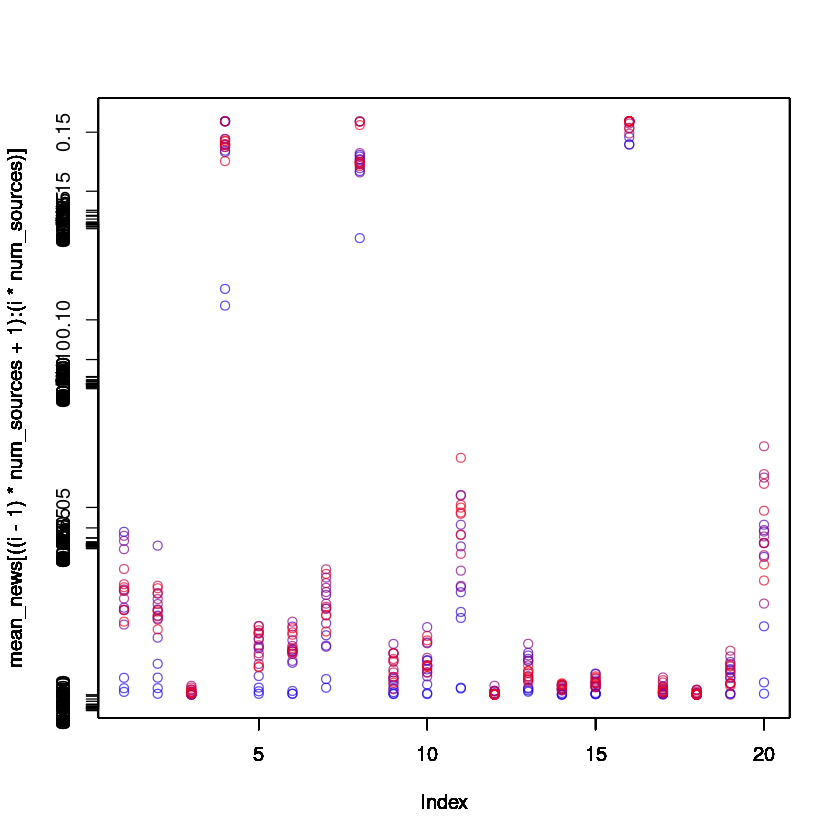

In [294]:
for(i in 1:memory){
    plot(mean_news[ ((i - 1) * num_sources + 1):( i * num_sources ) ], col=rgb(0.05*i,0,1 - 0.05*(i-1),0.7))
    par(new=TRUE)
}

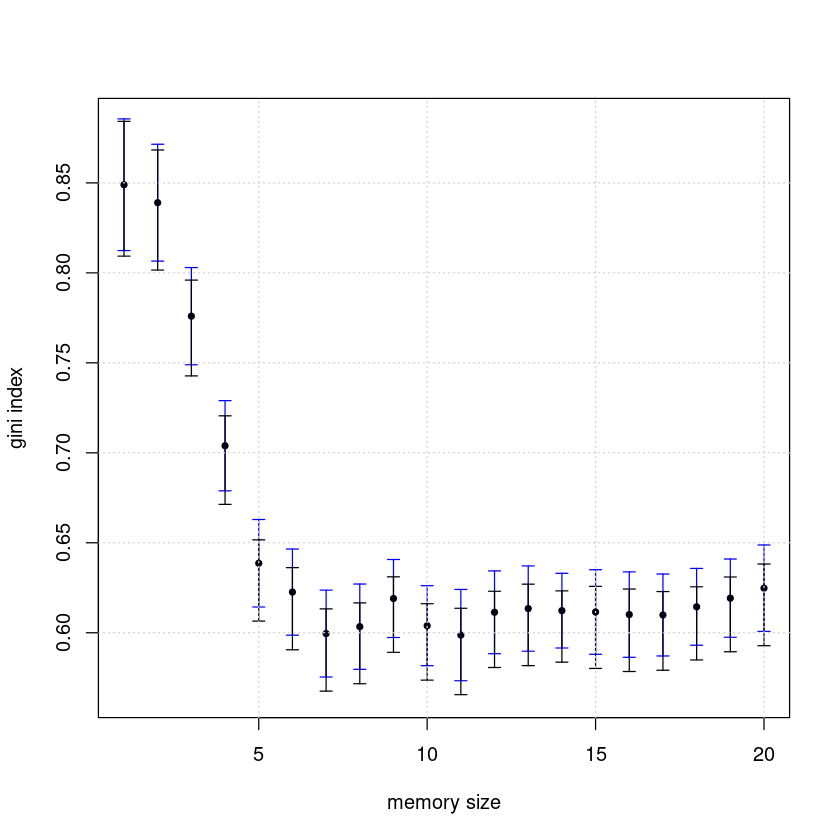

In [316]:
#https://stackoverflow.com/questions/13032777/scatter-plot-with-error-bars
Data <- data.frame(memory=c(1:20), gini=gini_news, giniup=gini_erru, ginidown=gini_errd, ginistd=gini_estd)

plot(Data$memory, Data$gini, xlab="memory size", ylab="gini index", pch=20, ylim=range(c(Data$gini-Data$ginidown, Data$gini+Data$giniup)))
arrows(Data$memory, Data$gini-Data$ginistd, Data$memory, Data$gini + Data$ginistd, length=0.05, angle=90, code=3, col='blue')
arrows(Data$memory, Data$gini-Data$ginidown, Data$memory, Data$gini + Data$giniup, length=0.05, angle=90, code=3)
par(new=TRUE)
grid()

[1] 1.4466788 1.7778744 1.0826849 0.6110536

[1] 1.4394214 1.7855667 1.0868405 0.6110741

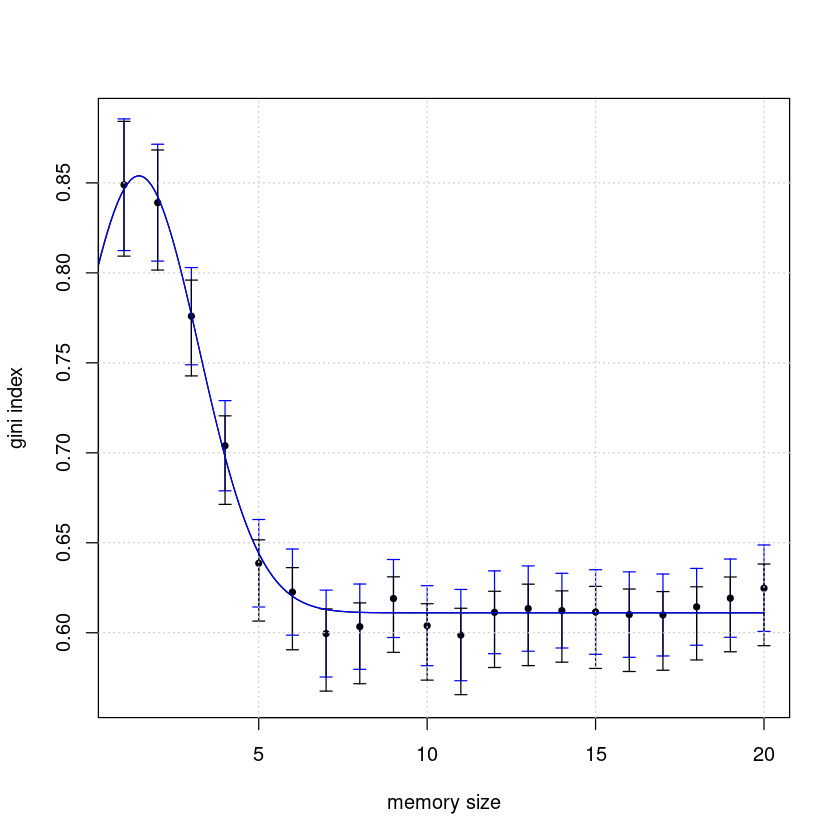

In [341]:
## https://stackoverflow.com/questions/15882323/r-robust-fitting-of-data-points-to-a-gaussian-function#15883835
fitG = function(x,y,w,mu,sig,scale,off){
    f = function(p){
        d = p[4] + p[3]*dnorm(x,mean=p[1],sd=p[2])
        sum((d-y)^2/(w^2))
    }
    optim(c(mu,sig,scale,off),f)
}

fitPboot = fitG(Data$memory, Data$gini, Data$giniup+Data$ginidown, 0.1,3.5,1.0,0.6)
fitPstd  = fitG(Data$memory, Data$gini, Data$ginistd, 0.1,3.5,1.0,0.6)
pboot = fitPboot$par
pstd  = fitPstd$par

plot(Data$memory, Data$gini, xlab="memory size", ylab="gini index", pch=20, ylim=range(c(Data$gini-Data$ginidown, Data$gini+Data$giniup)))
arrows(Data$memory, Data$gini-Data$ginistd, Data$memory, Data$gini + Data$ginistd, length=0.05, angle=90, code=3, col='blue')
arrows(Data$memory, Data$gini-Data$ginidown, Data$memory, Data$gini + Data$giniup, length=0.05, angle=90, code=3)
par(new=TRUE)
grid()

pboot
pstd
curve(normal(x, pboot[1], pboot[2], pboot[3], pboot[4]), 0, 20 ,n=200, add=TRUE)
curve(normal(x, pstd[1], pstd[2], pstd[3], pstd[4]), 0, 20 ,n=200, add=TRUE, col='blue')
#lines(Data$memory,pboot[4] + pboot[3]*dnorm(Data$memory,pboot[1],pboot[2]), col=2)
#lines(Data$memory,pstd[4] + pstd[3]*dnorm(Data$memory,pstd[1],pstd[2]), col='blue')

In [337]:
normal <- function(x, mu, sig, scale, off) { off + scale * dnorm(x, mu, sig) }

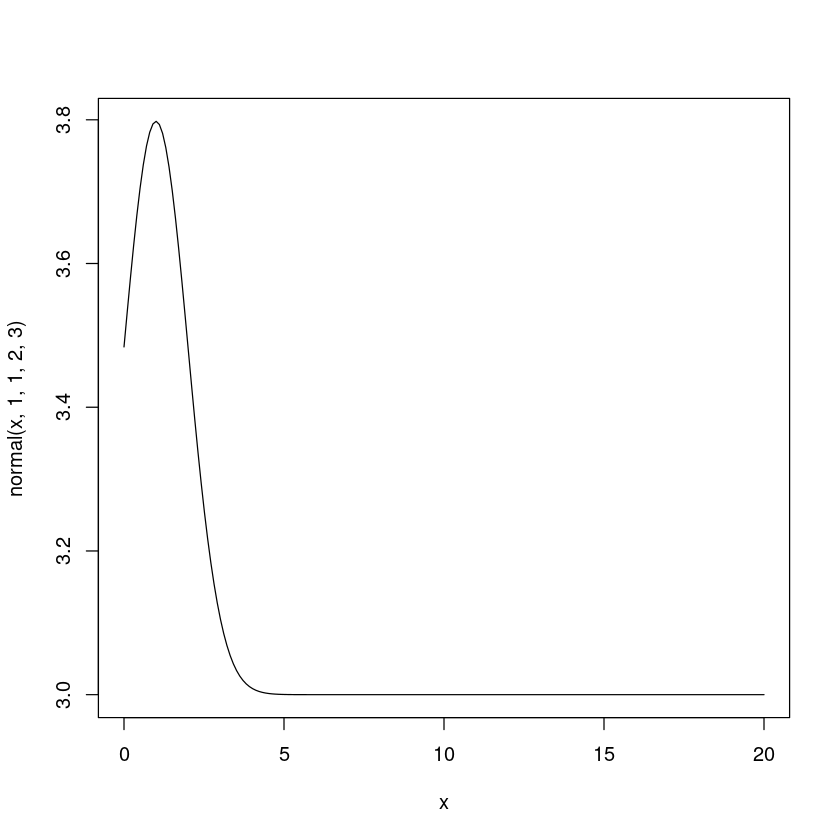

In [336]:
normal <- function(x, mu, sig, scale, off) { off + scale * dnorm(x, mu, sig) }
curve(normal(x, 1,1,2,3), 0,20,n=200)

[1] 0.0260438 0.0504198 0.0045844 0.1760992 0.0187056 0.0177322 0.0405616
 [8] 0.1698014 0.0097986 0.0252652 0.0376486 0.0053818 0.0147618 0.0070476
[15] 0.0083272 0.1815116 0.0049688 0.0043846 0.0099080 0.0552234

[1] 0.6033869

2.376943e-05


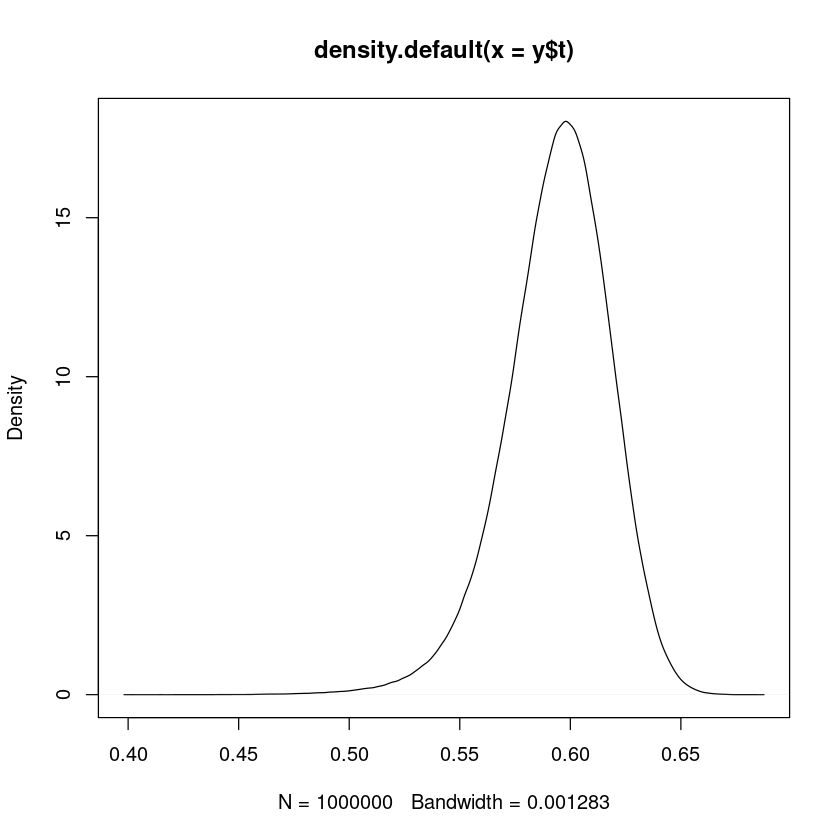

In [303]:
library(reldist) # just for the gini() function
library(boot) # for the boot() function
x <- mean_news[141:160]
mean_news[141:160]
gini(x)

#options(warn=-1)
y <- boot(data = x, statistic = gini, R = 1000000, parallel="multicore", ncpus=7)

#options(warn=0)

qq <- quantile(y$t, probs=c(0.025, 0.975))
plot(density(y$t))


In [302]:
quantile(y$t, probs=c(0.025, 0.975))

2.5%     97.5% 
0.5416115 0.6354093

In [306]:
sd(y$t)

[1] 0.02376943